In [5]:
import numpy as np #for numerical computations
import pandas as pd #for dataframe operations

from matplotlib import pyplot as plt #for viewing images and plots
%matplotlib inline 
#So that Matplotlib plots don't open in separate windows outside the notebook

import urllib #For fetching data from Web URLs

import cv2   #For image processing

from sklearn.preprocessing import LabelEncoder    #For encoding categorical variables
from sklearn.model_selection import train_test_split #For splitting of data
#All tensorflow utilities for creating, training and working with a CNN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

2024-02-10 21:21:25.477798: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
!pip install -U tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.8 MB/s eta 0:00:001 MB/s eta 0:00:01


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
df= pd.read_csv('datafile - boredApeCollection (1).csv')

In [44]:
df

,id,price,imageUrl
0,5465,72.6443,https://lh3.googleusercontent.com/Czn9y9yAUpvu...
1,8520,80.0000,https://lh3.googleusercontent.com/ULjfyo4LJhtV...
2,4671,91.0100,https://lh3.googleusercontent.com/Q4uXff5hD6T9...
3,212,91.0100,https://lh3.googleusercontent.com/-19OnF4JPSYK...
4,7941,105.0000,https://lh3.googleusercontent.com/4PmAMubiVIYG...
...,...,...,...
1064,3914,91.0100,https://lh3.googleusercontent.com/WERp6Dx06EDs...
1065,2380,91.0100,https://lh3.googleusercontent.com/BKLRvzF-tmnf...
1066,1904,91.0100,https://lh3.googleusercontent.com/_A-2RP8cU9sR...
1067,4619,91.2140,https://lh3.googleusercontent.com/qu4mPvRmNgAG...


In [45]:
def show_image_from_url(image_url):

  """
  Fetches image online from the image_url and plots it as it is using matplotlib's pyplot's image show
  """

  response = urllib.request.urlopen(image_url)
  image = np.asarray(bytearray(response.read()), dtype="uint8")
  image_bgr = cv2.imdecode(image, cv2.IMREAD_COLOR)
  image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
  plt.imshow(image_rgb), plt.axis('off')

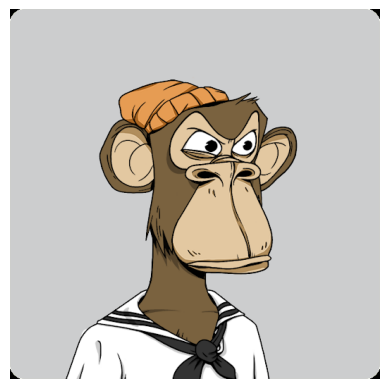

In [46]:
plt.figure()
show_image_from_url(df['imageUrl'].loc[11])

# load image from url 

In [47]:
def image_processing(image_url):
    #Download from image url and import it as a numpy array
    response = urllib.request.urlopen(image_url)
    image = np.asarray(bytearray(response.read()), dtype="uint8")                         

    #Read the numpy arrays as color images in OpenCV
    image_bgr = cv2.imdecode(image, cv2.IMREAD_COLOR)

    #Convert to HSV for creating a mask
    image_hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)

    #Convert to grayscale that will actually be used for training, instead of color image 
    image_gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)

    #Create a mask that detects the red rectangular tags present in each image
    mask = cv2.inRange(image_hsv, (0,255,255), (0,255,255))

    #Get the coordinates of the red rectangle in the image, 
    #But take entire image if mask fails to detect the red rectangle
    if len(np.where(mask != 0)[0]) != 0:
        y1 = min(np.where(mask != 0)[0])
        y2 = max(np.where(mask != 0)[0])
    else:
        y1 = 0                                     
        y2 = len(mask)

    if len(np.where(mask != 0)[1]) != 0:
        x1 = min(np.where(mask != 0)[1])
        x2 = max(np.where(mask != 0)[1])
    else:
        x1 = 0
        x2 = len(mask[0])

    #Crop the grayscle image along those coordinates
    image_cropped = image_gray[y1:y2, x1:x2]
    if image_cropped.size ==0:
        print(image_url)
        return image_cropped
    else:
    #Resize the image to 100x100 pixels size
        image_100x100 = cv2.resize(image_cropped, (100, 100))

    #Save image as in form of array of 10000x1
        image_arr = image_100x100.flatten()

    return image_arr


In [48]:
from tqdm import tqdm
import time

In [13]:
image_list = []

for url in tqdm(df['imageUrl'].tolist()[:]):
    image_list.append(image_processing(url))



  7%|█████▍                                                                     | 78/1069 [01:50<21:36,  1.31s/it]

https://lh3.googleusercontent.com/ue99OyDoYZGnehn0pqjJKnnFKgxMrgzKMQjfHAwrr8V3SN_RZdvkvUA-6BiRjYSRGs-jyGy0mq0LdoCv9So2n91KBW9tWRVtLStv=w525


 28%|████████████████████▉                                                     | 302/1069 [06:27<15:47,  1.24s/it]

https://lh3.googleusercontent.com/cPTBvpFJJ2-6sdQdHQC4q5OSX1Be7tJMSWfwEItdq7DNf106hzoNeC5F81G86Rkk6l9gDYuNV1ze4f-tC9VUOFr39uL8kbRGFHtPLQE=w525


 59%|████████████████████████████████████████████                              | 636/1069 [13:26<08:47,  1.22s/it]

https://lh3.googleusercontent.com/3Y9wkPHppbTC_dD8lG-Zpy8Ec0Yb2hurSjGeY6ki5D5tLVTbqKEJRXt8q4Q4cjCY8Q4DsqbWahUda9UIHGtmdru-xatEnMFP-5mx5A=w525


 74%|██████████████████████████████████████████████████████▊                   | 791/1069 [16:43<05:36,  1.21s/it]

https://lh3.googleusercontent.com/V7TTmfx_umaVJGwMZoDF5IWPxTLIf3Dm8ImCDdYoWGtNeZUwzsRNDL7zBilrUzDFPiMs6IvQWVy21TP7kU9gDeO2jeddyXOYpcrDfg=w525


 89%|█████████████████████████████████████████████████████████████████▊        | 950/1069 [20:04<02:28,  1.25s/it]

https://lh3.googleusercontent.com/5CWcxtqmYjk1A1w18R2E9DbpksXuqCGLzQge9iQ69MaW0gby6edkGdTn0hqSSb_ozNNgQ2_TbSQG837dmc_FHKpBwOQRSMli3hppjOg=w525


 91%|███████████████████████████████████████████████████████████████████▌      | 976/1069 [20:37<01:54,  1.23s/it]

https://lh3.googleusercontent.com/k6KPzW9H5DUCb_SRMyfJyFhcfGGkBnZeITg2ciWSRbV6MnvsB6MY2FtUNBL_1xMAJo0tCMIt3eks-OA_B45Zpnhy8JxpPra-IGxpeg=w525


100%|█████████████████████████████████████████████████████████████████████████| 1069/1069 [22:33<00:00,  1.27s/it]


In [49]:
X = np.array(image_list)
np.save('processed_100x100_image.npy',X/255,allow_pickle=True)

ape_array = np.load('processed_100x100_image.npy',allow_pickle=True)

/tmp/ipykernel_78990/3995652010.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(image_list)


In [50]:
ape_array = np.load('processed_100x100_image.npy',allow_pickle=True)

In [51]:
X = []
exclude =[]
for i in range(len(ape_array)):
    if ape_array[i].shape == (10000,):
        X.append(ape_array[i])
    else:
        exclude.append(i)
X =np.array(X)

In [52]:
X.shape

(1063, 10000)

In [53]:
df.drop(df.index[exclude],inplace=True)

In [54]:
ape_array[0:3]

array([array([0. , 0. , 0.8, ..., 0.8, 0. , 0. ]),
       array([0.        , 0.        , 0.80784314, ..., 0.80784314, 0.        ,
              0.        ])                                                    ,
       array([0.        , 0.03137255, 0.63921569, ..., 0.63921569, 0.72156863,
              0.        ])                                                    ],
      dtype=object)

## look at sample image 

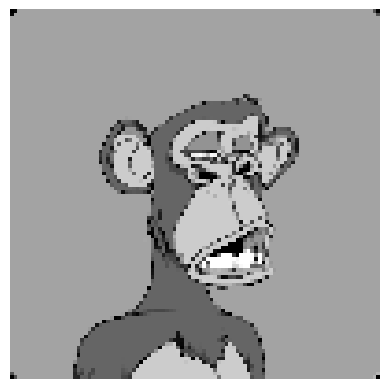

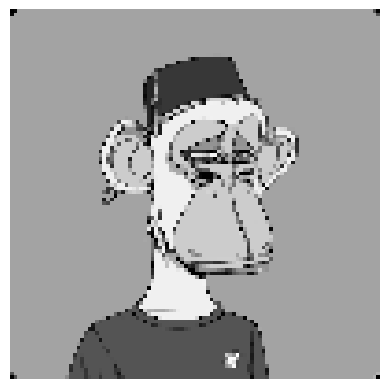

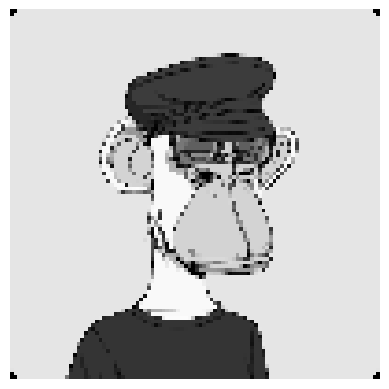

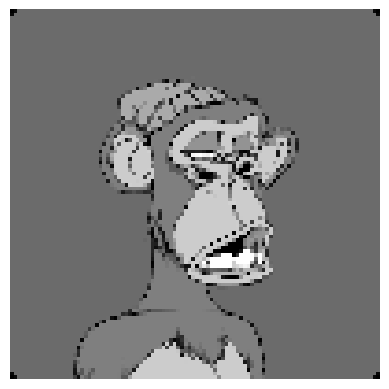

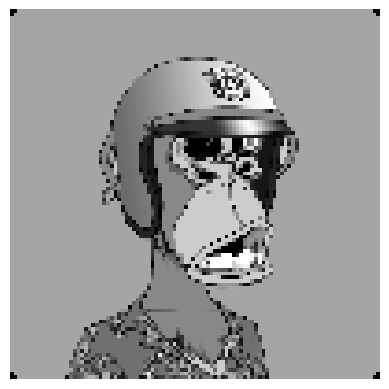

In [55]:
np.random.seed(17)
for i in np.random.randint(0, len(ape_array), 5):
    plt.figure()
    plt.imshow(ape_array[i].reshape(100, 100), cmap='gray'), plt.axis('off')

In [62]:
n_classes = df['price'].nunique()
print('Total number of unique categories:', n_classes)

Total number of unique categories: 218


In [105]:
encoder = LabelEncoder()
Targets = encoder.fit_transform(df['price'])
Y = df['price']
#Targets = df['price']
print(Targets)
print(Targets.shape)
print(Y.shape)

[3 4 7 ... 7 9 8]
(1063,)
(1063,)


In [106]:
Y = to_categorical(y=Targets, num_classes = n_classes)
print(Y[0:3])
print(Y.shape)

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [107]:
#Segregation of a test set for testing on the trained model

X_test = X[1000:,]
Y_test = Y[1000:,]

#Seperation of a validation set from the remaing training set (required for validation while training)

X_train, X_val, Y_train, Y_val = train_test_split(X[:1000,], Y[:1000,], test_size=0.15, random_state=13)

In [108]:
X_train.shape

(850, 10000)

In [109]:
img_rows, img_cols = 100, 100
input_shape = (img_rows, img_cols, 1)

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

X_val.shape

(150, 100, 100, 1)

In [110]:
#Define a Convolutional Neural Network Model

from tensorflow.keras.losses import sparse_categorical_crossentropy
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu',
                 input_shape = input_shape))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(n_classes, activation='softmax'))

learning_rate = 0.001

model.compile(loss = categorical_crossentropy,
              optimizer = Adam(learning_rate),
              metrics=['accuracy'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 98, 98, 16)        160       
                                                                 
 batch_normalization_36 (Bat  (None, 98, 98, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_37 (Conv2D)          (None, 96, 96, 16)        2320      
                                                                 
 batch_normalization_37 (Bat  (None, 96, 96, 16)       64        
 chNormalization)                                                
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 48, 48, 16)       0         
 g2D)                                                            
                                                      

In [89]:
save_at = "model.hdf5"
save_best = ModelCheckpoint (save_at, monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='max')

In [97]:
# from tensorflow.keras.utils import to_categorical

# Y_train = to_categorical(Y_train, 218)
# Y_val = to_categorical(Y_val, 218)
print(Y_train)

589     91.01
632     91.01
255    222.22
265    247.00
515    101.00
        ...  
745     91.01
530    101.00
74     140.00
177    177.00
340    420.42
Name: price, Length: 850, dtype: float64


Epoch 1/20
9/9 [==============================] - 10s 841ms/step - loss: 8.0333 - accuracy: 0.2224 - val_loss: 5.1847 - val_accuracy: 0.4800
Epoch 2/20
9/9 [==============================] - 6s 684ms/step - loss: 3.9494 - accuracy: 0.3800 - val_loss: 3.5184 - val_accuracy: 0.4800
Epoch 3/20
9/9 [==============================] - 6s 632ms/step - loss: 3.7214 - accuracy: 0.4000 - val_loss: 4.6590 - val_accuracy: 0.4800
Epoch 4/20
9/9 [==============================] - 6s 671ms/step - loss: 3.6348 - accuracy: 0.4071 - val_loss: 4.9607 - val_accuracy: 0.4800
Epoch 5/20
9/9 [==============================] - 6s 708ms/step - loss: 3.5827 - accuracy: 0.4035 - val_loss: 5.6903 - val_accuracy: 0.4800
Epoch 6/20
9/9 [==============================] - 6s 670ms/step - loss: 3.4762 - accuracy: 0.4094 - val_loss: 7.1754 - val_accuracy: 0.4800
Epoch 7/20
9/9 [==============================] - 7s 768ms/step - loss: 3.4676 - accuracy: 0.4094 - val_loss: 8.7639 - val_accuracy: 0.4800
Epoch 8/20
9/9 [===

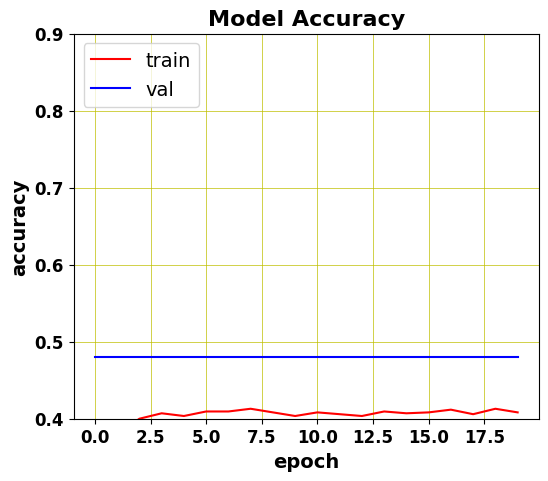

In [111]:
    #Train the CNN

history = model.fit( X_train, Y_train, 
                    epochs = 20, batch_size = 100, 
                    callbacks=[save_best], verbose=1, 
                    validation_data = (X_val, Y_val))

# Plot the training history (Training accuracy & Validation accuracy)

plt.figure(figsize=(6, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy', weight='bold', fontsize=16)
plt.ylabel('accuracy', weight='bold', fontsize=14)
plt.xlabel('epoch', weight='bold', fontsize=14)
plt.ylim(0.4, 0.9)
plt.xticks(weight='bold', fontsize=12)
plt.yticks(weight='bold', fontsize=12)
plt.legend(['train', 'val'], loc='upper left', prop={'size': 14})
plt.grid(color = 'y', linewidth='0.5')
plt.show()

In [112]:
#Run model on the held-out test set

model = load_model('model.hdf5')
score = model.evaluate(X_test, Y_test, verbose=0)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

Accuracy over the test set: 
  85.71 %


In [113]:
# import classification_report
from sklearn.metrics import classification_report

pred = model.predict(X_test)

# turn a array of prediction probability to predicted value
test_predictions = np.argmax(pred, axis=-1)
Y_test_labels = np.argmax(Y_test, axis=-1)

print(classification_report(Y_test_labels,test_predictions))

2/2 [==============================] - 0s 164ms/step
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         2
           7       0.86      1.00      0.92        54
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1

    accuracy                           0.86        63
   macro avg       0.14      0.17      0.15        63
weighted avg       0.73      0.86      0.79        63



/home/labeeb/miniconda3/envs/nft-cnn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/labeeb/miniconda3/envs/nft-cnn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/labeeb/miniconda3/envs/nft-cnn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

2/2 [==============================] - 0s 176ms/step


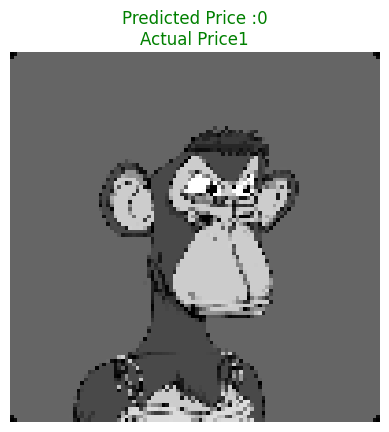

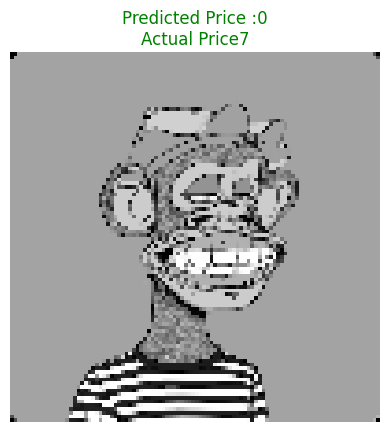

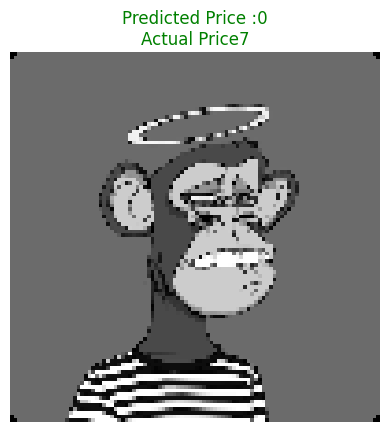

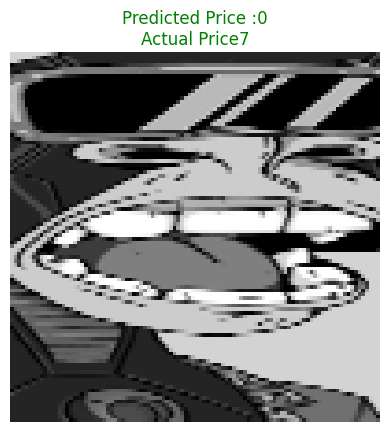

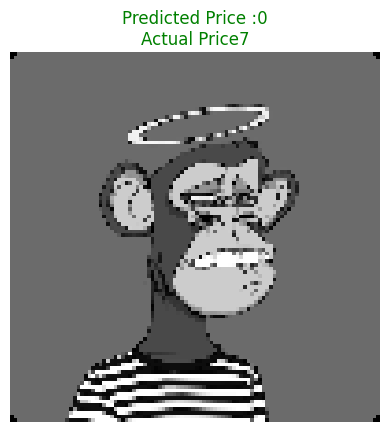

In [114]:
Y_pred = np.round(model.predict(X_test))

np.random.seed(87)
for rand_num in np.random.randint(0, len(Y_test), 5):
    plt.figure()
    plt.imshow(X_test[rand_num].reshape(100, 100),cmap='gray'), plt.axis('off')
    if np.where(Y_pred[rand_num] == 1)[0].sum() == np.where(Y_test[rand_num] == 1)[0].sum():
        plt.title(np.where(Y_pred[rand_num] == 1)[0].sum(), color='r')
    else :
        plt.title('Predicted Price :' + str(np.where(Y_pred[rand_num] == 1)[0].sum()) + "\n" +"Actual Price" + str(Y_test_labels[rand_num]), color='g')
        #plt.title('Predicted Price :' + str(encoder.classes_[np.where(Y_pred[rand_num] == 1)[0].sum()]), color='g')



#plt.title('Predicted price : ' +str(Y_pred[rand_num]) +' dollars' + '\nReal price : ' +str(Y_pred[rand_num]) +' dollars' , color='g')



In [115]:
import re 

df['price'] = df.price.apply(float)

In [116]:
df['price']

0        72.6443
1        80.0000
2        91.0100
3        91.0100
4       105.0000
          ...   
1064     91.0100
1065     91.0100
1066     91.0100
1067     91.2140
1068     91.0610
Name: price, Length: 1063, dtype: float64

In [117]:
#Define a Convolutional Neural Network Model

model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu',
                 input_shape = input_shape))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
#model.add(Dense(n_classes, activation='softmax'))
model.add(Dense(1, activation='relu'))
learning_rate = 0.001

model.compile(loss = 'mse',
              optimizer = Adam(learning_rate))

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 98, 98, 16)        160       
                                                                 
 batch_normalization_40 (Bat  (None, 98, 98, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_41 (Conv2D)          (None, 96, 96, 16)        2320      
                                                                 
 batch_normalization_41 (Bat  (None, 96, 96, 16)       64        
 chNormalization)                                                
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 48, 48, 16)       0         
 g2D)                                                            
                                                     

In [118]:
save_at = "model_regression.hdf5"
save_best2 = ModelCheckpoint (save_at, monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='max')

In [119]:
Y_price = np.array(df.price.tolist())
Y_price_train = Y_price[:len(X_train)]
Y_price_test = Y_price[1000:]
Y_price_val = Y_price[len(X_train):1000]

In [120]:
history = model.fit( X_train, Y_price_train, 
                    epochs = 20, batch_size = 100, 
                    callbacks=[save_best2], verbose=1, 
                   validation_data = (X_val, Y_price_val))

Epoch 1/20
9/9 [==============================] - 8s 741ms/step - loss: 731476.7500 - val_loss: 7635.5156
Epoch 2/20
9/9 [==============================] - 7s 773ms/step - loss: 710067.4375 - val_loss: 6935.6235
Epoch 3/20
9/9 [==============================] - 6s 652ms/step - loss: 705875.7500 - val_loss: 5754.3989
Epoch 4/20
9/9 [==============================] - 6s 663ms/step - loss: 704609.1250 - val_loss: 3263.5461
Epoch 5/20
9/9 [==============================] - 6s 682ms/step - loss: 698358.5625 - val_loss: 1925.0275
Epoch 6/20
9/9 [==============================] - 6s 648ms/step - loss: 685061.6250 - val_loss: 992.9471
Epoch 7/20
9/9 [==============================] - 6s 647ms/step - loss: 672081.6250 - val_loss: 659.8779
Epoch 8/20
9/9 [==============================] - 6s 632ms/step - loss: 677684.0000 - val_loss: 1439.6898
Epoch 9/20
9/9 [==============================] - 6s 628ms/step - loss: 646584.6875 - val_loss: 3533.1021
Epoch 10/20
9/9 [==============================]

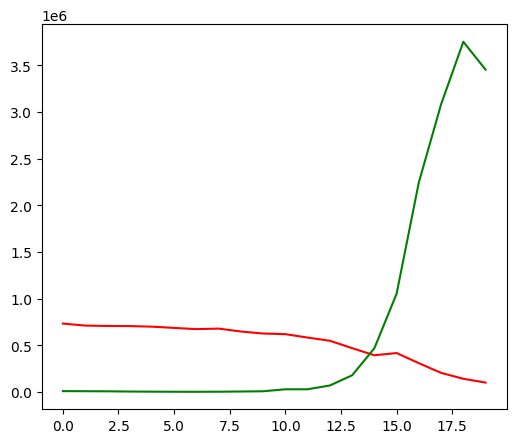

In [121]:
plt.figure(figsize=(6, 5))
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='g')
plt.show()

2/2 [==============================] - 0s 159ms/step


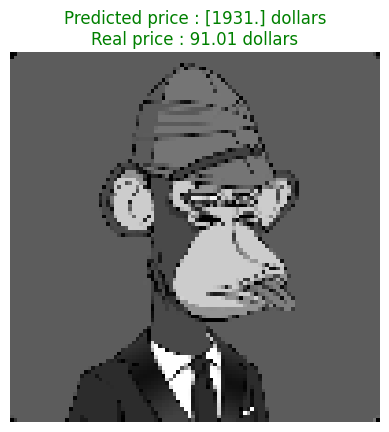

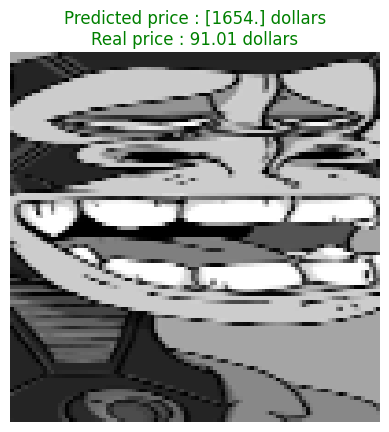

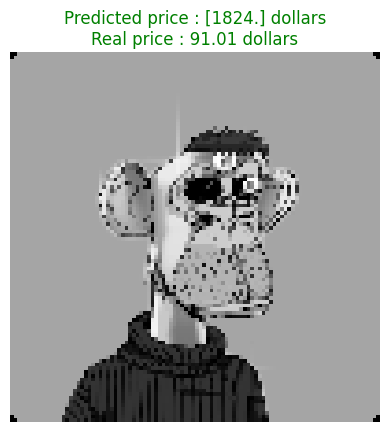

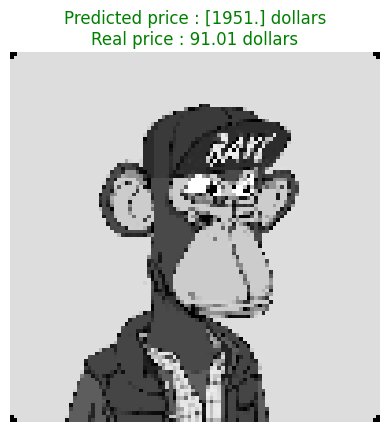

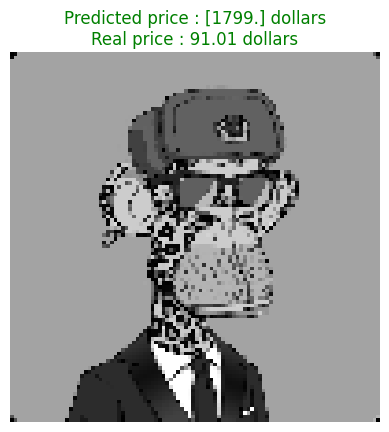

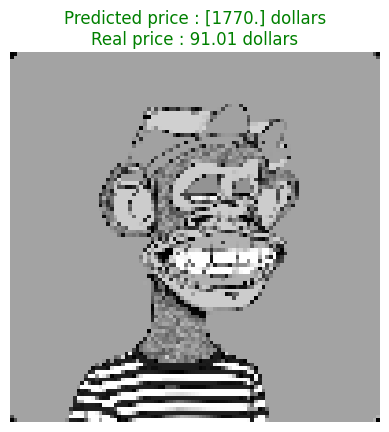

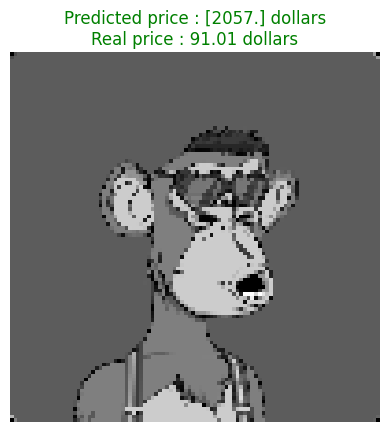

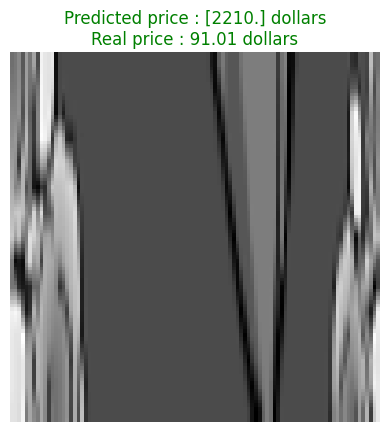

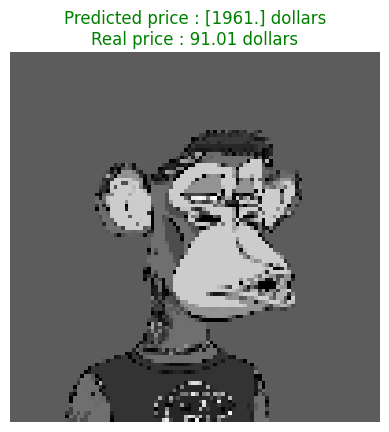

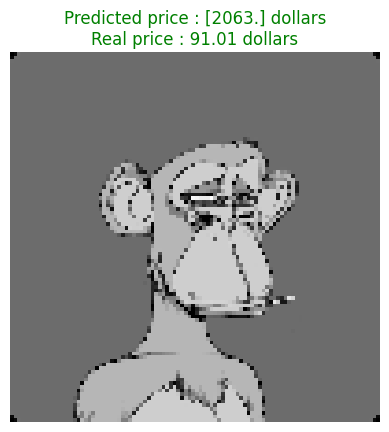

In [122]:
Y_pred = np.round(model.predict(X_test))

np.random.seed(11)
for rand_num in np.random.randint(0, len(Y_test), 10):
    plt.figure()
    plt.imshow(X_test[rand_num].reshape(100, 100),cmap='gray'), plt.axis('off')
    #plt.title('Predicted price : ' +str(Y_pred[rand_num]) +' dollars' + '\nReal price : ' +str(Y_price_test[rand_num]) +' dollars' , color='g')
    plt.title('Predicted price : ' +str(Y_pred[rand_num]) +' dollars' + '\nReal price : ' +str(Y_price_test[rand_num]) +' dollars' , color='g')
